# Surface observation postprocessing 


In these note books we try some machine learning techniques on a real world but simple problem.

We are trying to improve the ECMWF IFS forecast of temperature using postprocessing. 

Specifically we are trying to predict the difference between station observations of 2m-temperature and the IFS forecast prediction at the nearest gridpoint to the observation location.

We will explore several physically motivated predictors.

# Using gradient boosted trees (XGBoost)

In [1]:
# An example of using machine learning to model weather forecast error 
# based on work of Matthew Chantry and Fenwick Cooper as part of work 
# funded by IFAB (https://www.ifabfoundation.org/)

# A few imports of tools we will use. Where possible it is always worth using
# existing tools, even if the mathematics are simple to write down yourself.
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from sop_utils import imgBufferFromVectors
import climetlab as cml

In [2]:
!pip install climetlab-mltc-surface-observation-postprocessing --quiet

In [3]:
# Load a list of 36 hour forecast errors in 2m temperature.
# The forecasts come from ECMWF's high resolution forecast system.
# The measurements come from around 8000 weather stations around the world.
forecast_error = cml.load_dataset('mltc-surface-observation-postprocessing',field='forecast_error').to_numpy()

# We suspect that the errors in the forecast can be explained simply by the time of day.

# Load the local time of day corresponding to when the measurements were made.
time_of_day = cml.load_dataset('mltc-surface-observation-postprocessing',field='time_of_day').to_numpy()

# Later we will add in the soil temperature
soil_temperature = cml.load_dataset('mltc-surface-observation-postprocessing',field='soil_temperature').to_numpy()

# Note that an important step of data preprocessing has already been carried out in the curation of the dataset.
# Spurious data has already been removed from the dataset based upon a range of categories,
# e.g. stations with inconsistent measurement locations, repeated values, or even physically 
# invalid numbers (>100C).
# If you are starting on a new project this is a key step to clean the data.

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/mchantry/climetlab-mltc-sop/blob/main/LICENSE. If you do not agree with such terms, do not download the data. 


In [4]:
# Split each of the predictands and predictors in a random train/test split
# we use 80% of the data for training & 20% for testing

# Here the data has already been anonymized, so we cannot use information about
# stations or time to ensure independence of our dataset.
# With more meta-data we could follow the lessons learnt earlier today
# and ensure the data subsets are independent
(forecast_error_train, forecast_error_test, 
 time_of_day_train, time_of_day_test, 
 soil_temperature_train,  soil_temperature_test) = train_test_split(forecast_error,
                                                                    time_of_day,
                                                                    soil_temperature,
                                                                    test_size = 0.2,
                                                                    random_state = 42)

In [5]:
forecast_error_train.shape, forecast_error_test.shape

((4212390, 1), (1053098, 1))

**NB**: XGBoost doesn't require that the inputs be normalized. So we can go ahead and fit the model.

In [6]:
import xgboost as xgb

reg_one_var = xgb.XGBRegressor(n_estimators=5, eval_metric=mean_absolute_error)
reg_one_var = reg_one_var.fit(
    time_of_day_train, forecast_error_train,
    # calculate the RMSE on the eval (holdout) set
    eval_set=[(time_of_day_test, forecast_error_test)],
)
reg_one_var

/opt/anaconda3/envs/ecmwf-ml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-rmse:2.27500
[1]	validation_0-rmse:2.24054
[2]	validation_0-rmse:2.22326
[3]	validation_0-rmse:2.21471
[4]	validation_0-rmse:2.21049
[5]	validation_0-rmse:2.20841
[6]	validation_0-rmse:2.20736
[7]	validation_0-rmse:2.20677
[8]	validation_0-rmse:2.20647
[9]	validation_0-rmse:2.20633
[10]	validation_0-rmse:2.20625
[11]	validation_0-rmse:2.20620
[12]	validation_0-rmse:2.20617
[13]	validation_0-rmse:2.20615
[14]	validation_0-rmse:2.20615
[15]	validation_0-rmse:2.20614
[16]	validation_0-rmse:2.20615
[17]	validation_0-rmse:2.20615
[18]	validation_0-rmse:2.20615
[19]	validation_0-rmse:2.20615


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7f67ec69a310>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [9]:
# Let's see how our model works across all the hours of the day
x_rep = np.arange(0,24,0.001)[...,np.newaxis]
y = reg_one_var.predict(x_rep)
y

array([0.59593296, 0.59593296, 0.59593296, ..., 0.45807698, 0.45807698,
       0.45807698], dtype=float32)

In [11]:
# Make an image of the time of day against the forecast error
tod_buffer, ax_extent, count = imgBufferFromVectors(time_of_day_test, forecast_error_test,
                                                    nx=256, ny=256, extent=[],
                                                    calc_average=False)

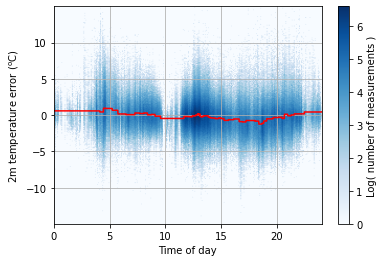

In [12]:
# Plot the number of measurements at each time of day and forecast error
plt.imshow(np.log((count==0.0)+count),
           cmap='Blues', origin='lower',
           extent=ax_extent, aspect='auto')

plt.xlim([0, 24])
plt.grid()
plt.xlabel('Time of day')
plt.ylabel('2m temperature error ($^\mathrm{o}$C)')
cb = plt.colorbar()
cb.set_label('Log( number of measurements )')

# Line of best fit
plt.plot(x_rep,y,'red')

plt.show()

# Note: The model (red line) is better than nothing, but does not account for the variation
#       in 2m temperature error at single time of day (eg. at 14:00).
#
#       Another predictor is required. We try using the soil temperature.
#
#       In comparison to the regression model, the result of the neural network is
#       less smooth which can be a good OR a bad thing

In [15]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

forecast_corrected = forecast_error_test.squeeze() - reg_one_var.predict(time_of_day_test)

print('Mean Absolute Error Corrected:', metrics.mean_absolute_error(zero_test, forecast_corrected))
print('Root Mean Squared Error Corrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_corrected)))

Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.5830179891963572
Root Mean Squared Error Corrected: 2.206251092888295


## Adding more predictors

Next we will add a second predictor, the model soil temperature.

As we will see below, there is a complex structure in the pattern of forecast error in the 2D space of time of day & soil temperature. How well can the model learn this?


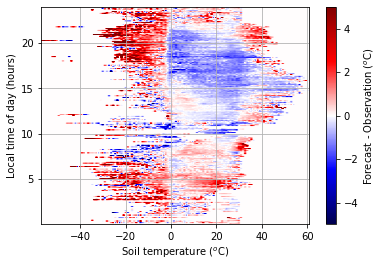

In [16]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(soil_temperature_test,
                                                time_of_day_test,
                                                forecast_error_test,
                                                128, 256,
                                                extent = [],
                                                calc_average=True)
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

In the above we see clear structure, where the in evening the forecast is too warm if the soil is frozen and too cold if the soil is not.

Can we learn a good representation of this error pattern?

In [17]:
#Create the input features
X_train = np.concatenate([time_of_day_train, soil_temperature_train],axis=-1)
X_test = np.concatenate([time_of_day_test, soil_temperature_test],axis=-1)

reg_two_vars = xgb.XGBRegressor(n_estimators=10, eval_metric=mean_absolute_error)
reg_two_vars = reg_two_vars.fit(
    X_train, forecast_error_train,
    eval_set=[(X_test, forecast_error_test)],
)

[0]	validation_0-rmse:2.25423
[1]	validation_0-rmse:2.20757
[2]	validation_0-rmse:2.18370
[3]	validation_0-rmse:2.17001
[4]	validation_0-rmse:2.16265
[5]	validation_0-rmse:2.15852
[6]	validation_0-rmse:2.15550
[7]	validation_0-rmse:2.15365
[8]	validation_0-rmse:2.15244
[9]	validation_0-rmse:2.15146


In [20]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

forecast_corrected = forecast_error_test.squeeze() - reg_two_vars.predict(X_test)

print('Mean Absolute Error Corrected:', metrics.mean_absolute_error(zero_test, forecast_corrected))
print('Root Mean Squared Error Corrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_corrected)))

Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.5489480421662545
Root Mean Squared Error Corrected: 2.151563594739748


### By using two predictors we can impove the forecast of 2m-temperature by ~0.1 C.

### Let's see how the model corrects the forecast across the full 2D space.

In [22]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image, this covers
# the range of data observed in the data
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0],ax_extent[1],nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2],ax_extent[3],ny)  # Represents time_of_day

# Create the input data
input_buffer = np.stack(np.meshgrid(y_tod,x_st),axis=-1)
X_plot = input_buffer.reshape(-1,X_train.shape[-1])

#Predict and reshape prediction back to 2D plot
raw_pred = reg_two_vars.predict(X_plot)
model_buffer = raw_pred.reshape(input_buffer.shape[:-1])

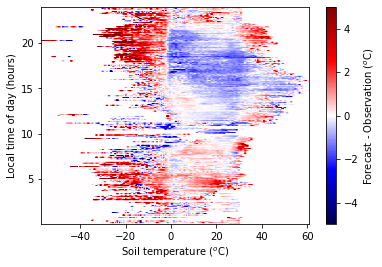

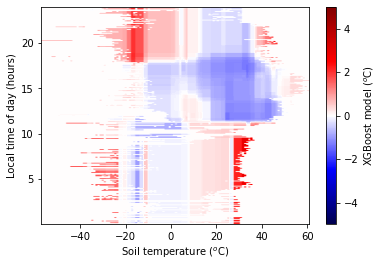

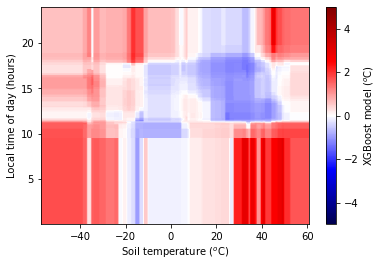

In [23]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

#plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Plot the model
plt.imshow((model_buffer)*(count>0), vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

#plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('XGBoost model ($^o$C)')

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

#plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('XGBoost model ($^o$C)')

plt.show()

As we add more predictors and complexity to our model, it becomes better and better. But, our measurements of the forecast error are not perfect. There is some noise. We don't want our model to capture this. But a complex model will. We need a simpler model, or more data. Fitting a model that is too complex for the data is called "overfitting". Here we have a large number of observations and still relatively small number of free parameters, so overfitting is unlikely. We see that during training our errors on the training & testing dataset are comparable.

Away from where data has been provided the model does not have constraints. We should not trust this part of the space.

We also see different model corrections for hour 23 and hour 0, when these should be closely correlated.


# Extensions:

1. Can you beat my predictions by changing the [XGBRegressor parameters](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn)? To avoid overfitting on the test (hold-out dataset), you could split the data into a train, validation, and test dataset. Use the train and validation datasets to explore the design space of the XGBRegressor, then run your best model against the test dataset and compare it with your best neural network.

2. Is there a way of building in any prior knowledge to even this simple setup? Perhaps you can encode the fact that 0 hour follows 23? Does this help the prediction?

3. What is more important for the final prediction? Is it the time-of-day or the soil temperature? You may want to look at the feature importances calculated by XGBoost.

4. Can you explain the different error patterns in the two-variable error plots? The neural network errors appear to be "smoother" than those of the XGBoost regressor - why is that?

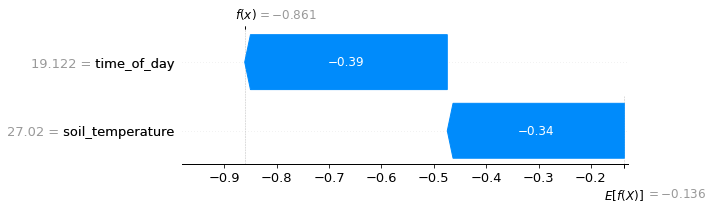

In [31]:
import shap

explainer = shap.Explainer(reg_two_vars, feature_names=["time_of_day", "soil_temperature"])
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

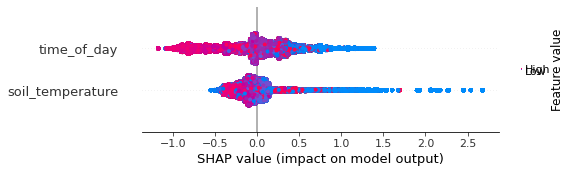

In [32]:
shap.plots.beeswarm(shap_values)